In [1]:

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))
# pandas
import pandas as pd
from pandas import Series,DataFrame

# numpy, matplotlib, seaborn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb

In [2]:
# get expedia & test csv files as a DataFrame
expedia_df = pd.read_csv('../input/expedia-hotel-recommendations/train.csv', nrows=10000)
test_df    = pd.read_csv('../input/expedia-hotel-recommendations/test.csv')

# preview the data
expedia_df.head()

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,...,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster
0,2014-08-11 07:46:59,2,3,66,348,48862,2234.2641,12,0,1,...,0,1,8250,1,0,3,2,50,628,1
1,2014-08-11 08:22:12,2,3,66,348,48862,2234.2641,12,0,1,...,0,1,8250,1,1,1,2,50,628,1
2,2014-08-11 08:24:33,2,3,66,348,48862,2234.2641,12,0,0,...,0,1,8250,1,0,1,2,50,628,1
3,2014-08-09 18:05:16,2,3,66,442,35390,913.1932,93,0,0,...,0,1,14984,1,0,1,2,50,1457,80
4,2014-08-09 18:08:18,2,3,66,442,35390,913.6259,93,0,0,...,0,1,14984,1,0,1,2,50,1457,21


In [3]:
expedia_df.info()
print("----------------------------")
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 24 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   date_time                  10000 non-null  object 
 1   site_name                  10000 non-null  int64  
 2   posa_continent             10000 non-null  int64  
 3   user_location_country      10000 non-null  int64  
 4   user_location_region       10000 non-null  int64  
 5   user_location_city         10000 non-null  int64  
 6   orig_destination_distance  6271 non-null   float64
 7   user_id                    10000 non-null  int64  
 8   is_mobile                  10000 non-null  int64  
 9   is_package                 10000 non-null  int64  
 10  channel                    10000 non-null  int64  
 11  srch_ci                    9993 non-null   object 
 12  srch_co                    9993 non-null   object 
 13  srch_adults_cnt            10000 non-null  int6

In [4]:
# drop unnecessary columns, these columns won't be useful in analysis and prediction
expedia_df = expedia_df.drop(['date_time','site_name', 'user_location_region', 'user_location_city', 'orig_destination_distance', 
                              'user_id', 'srch_co', 'srch_adults_cnt', 'srch_children_cnt', 'srch_rm_cnt', 'cnt'], axis=1)
test_df    = test_df.drop(['date_time','site_name', 'user_location_region', 'user_location_city', 'orig_destination_distance', 
                              'user_id', 'srch_co', 'srch_adults_cnt', 'srch_children_cnt', 'srch_rm_cnt'], axis=1)

### check data outlook

In [5]:
expedia_df.head()

,posa_continent,user_location_country,is_mobile,is_package,channel,srch_ci,srch_destination_id,srch_destination_type_id,is_booking,hotel_continent,hotel_country,hotel_market,hotel_cluster
0,3,66,0,1,9,2014-08-27,8250,1,0,2,50,628,1
1,3,66,0,1,9,2014-08-29,8250,1,1,2,50,628,1
2,3,66,0,0,9,2014-08-29,8250,1,0,2,50,628,1
3,3,66,0,0,3,2014-11-23,14984,1,0,2,50,1457,80
4,3,66,0,0,3,2014-11-23,14984,1,0,2,50,1457,21


In [6]:
expedia_df[expedia_df['is_booking']==1]

,posa_continent,user_location_country,is_mobile,is_package,channel,srch_ci,srch_destination_id,srch_destination_type_id,is_booking,hotel_continent,hotel_country,hotel_market,hotel_cluster
1,3,66,0,1,9,2014-08-29,8250,1,1,2,50,628,1
20,3,66,0,1,4,2014-04-18,8291,1,1,2,50,191,2
27,4,195,0,1,9,2013-09-06,1385,1,1,0,185,185,58
72,4,195,0,0,9,2015-06-26,8803,1,1,3,151,69,36
79,3,66,0,1,1,2014-02-22,12009,1,1,2,50,680,95
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9946,3,66,0,0,0,2014-04-20,12277,6,1,2,50,191,28
9953,3,66,0,0,0,2014-05-16,12279,6,1,2,50,191,28
9964,3,66,0,0,0,2014-08-13,12576,5,1,2,50,676,33
9974,3,66,0,0,0,2014-08-28,11994,6,1,2,50,694,72


In [7]:
set(expedia_df['hotel_continent'].tolist())

{0, 2, 3, 4, 5, 6}

In [8]:
pd.to_datetime(expedia_df['srch_ci'].tolist())

DatetimeIndex(['2014-08-27', '2014-08-29', '2014-08-29', '2014-11-23',
               '2014-11-23', '2014-11-23', '2014-08-01', '2014-08-01',
               '2014-08-01', '2014-08-01',
               ...
               '2013-05-28', '2013-05-29', '2014-06-09', '2014-06-09',
               '2014-08-28', '2014-08-28', '2014-08-28', '2014-08-29',
               '2014-08-29', '2014-08-28'],
              dtype='datetime64[ns]', length=10000, freq=None)

In [9]:
min(pd.to_datetime(expedia_df['srch_ci'].tolist()))

Timestamp('2013-01-08 00:00:00')

In [10]:
max(pd.to_datetime(expedia_df['srch_ci'].tolist()))

Timestamp('2015-12-28 00:00:00')

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='hotel_country', ylabel='count'>

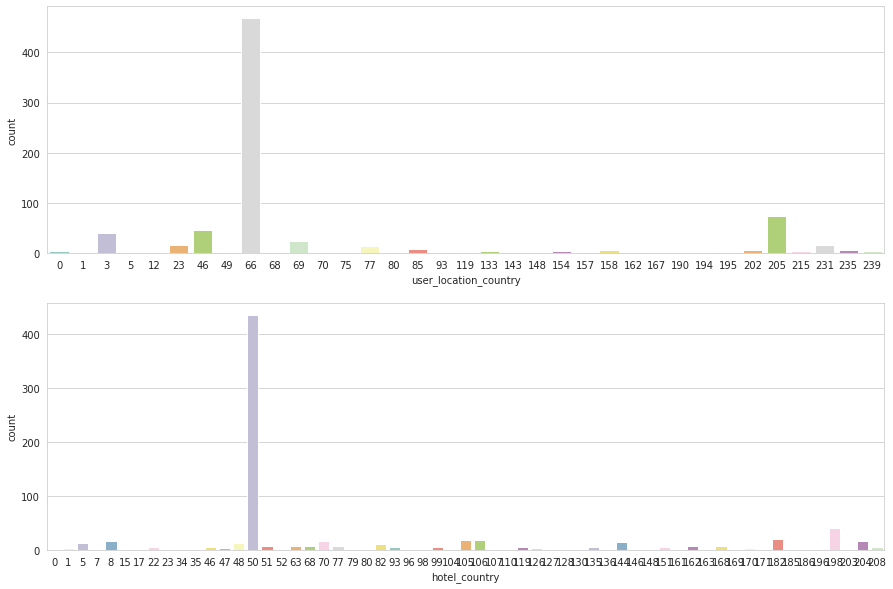

In [11]:
# Plot 

fig, (axis1,axis2) = plt.subplots(2,1,figsize=(15,10))

bookings_df = expedia_df[expedia_df["is_booking"] == 1]

# What are the most countries the customer travel from?
sns.countplot('user_location_country',data=bookings_df.sort_values(by=['user_location_country']),ax=axis1,palette="Set3")

# What are the most countries the customer travel to?
sns.countplot('hotel_country',data=bookings_df.sort_values(by=['hotel_country']),ax=axis2,palette="Set3")

# Combine both plots
# fig, (axis1) = plt.subplots(1,1,figsize=(15,5))

# sns.distplot(bookings_df["hotel_country"], kde=False, rug=False, bins=25, ax=axis1)
# sns.distplot(bookings_df["user_location_country"], kde=False, rug=False, bins=25, ax=axis1)

### # Where do most of the customers from a country 66 travel?

<AxesSubplot:>

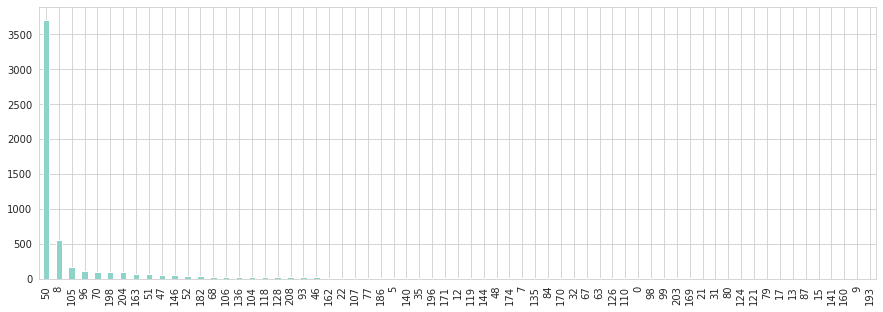

In [12]:

user_country_id = 66

fig, (axis1) = plt.subplots(1,1,figsize=(15,10))

country_customers = expedia_df[expedia_df["user_location_country"] == user_country_id]
country_customers["hotel_country"].value_counts().plot(kind='bar',colormap="Set3",figsize=(15,5))

### Plot frequency for each hotel_clusters

<AxesSubplot:>

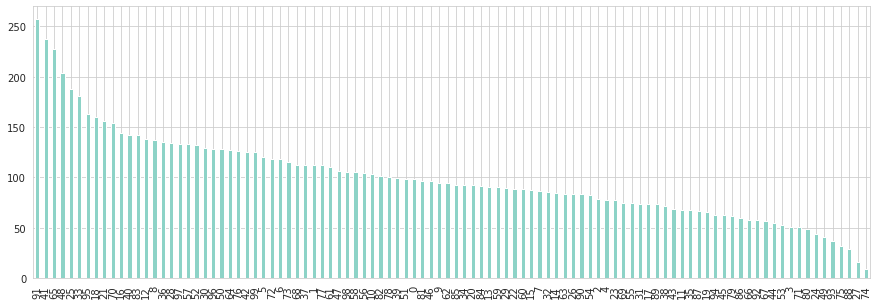

In [13]:
expedia_df["hotel_cluster"].value_counts().plot(kind='bar',colormap="Set3",figsize=(15,5))

### most frequent hotel clusters booked by customers from a country 66

<AxesSubplot:>

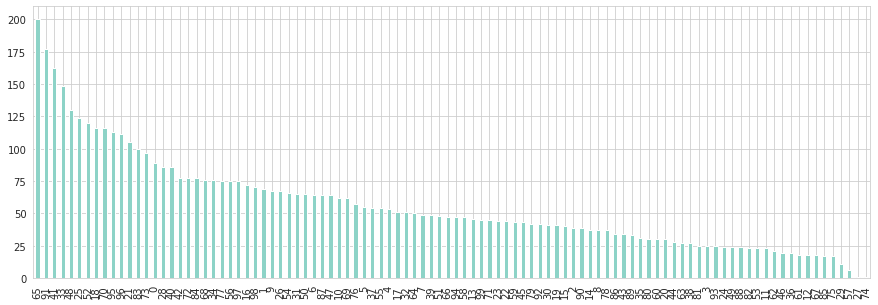

In [14]:

user_country_id = 66

fig, (axis1) = plt.subplots(1,1,figsize=(15,10))

customer_clusters = expedia_df[expedia_df["user_location_country"] == user_country_id]["hotel_cluster"]
customer_clusters.value_counts().plot(kind='bar',colormap="Set3",figsize=(15,5))

### most frequent hotel clusters in a country 50

<AxesSubplot:>

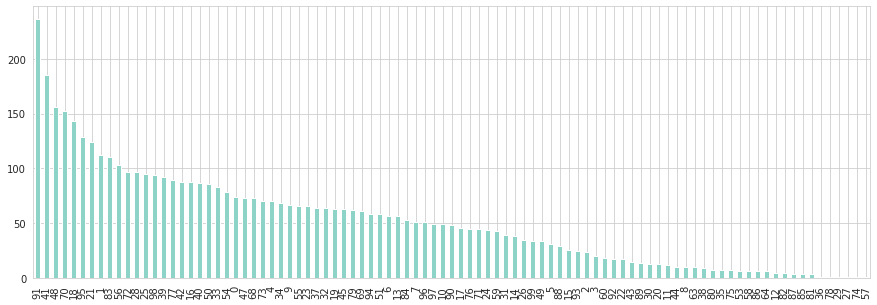

In [15]:

country_id = 50

fig, (axis1) = plt.subplots(1,1,figsize=(15,10))

country_clusters = expedia_df[expedia_df["hotel_country"] == country_id]["hotel_cluster"]
country_clusters.value_counts().plot(kind='bar',colormap="Set3",figsize=(15,5))



/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn

<AxesSubplot:xlabel='hotel_continent', ylabel='count'>

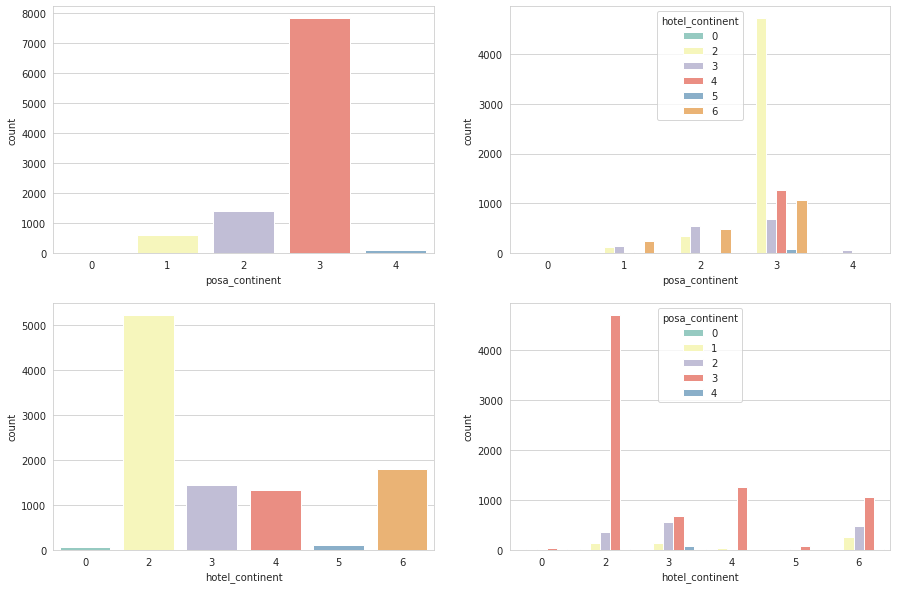

In [16]:
# Plot post_continent & hotel_continent

fig, ((axis1,axis2),(axis3,axis4)) = plt.subplots(2,2,figsize=(15,10))

# Plot frequency for each posa_continent
sns.countplot('posa_continent', data=expedia_df,order=[0,1,2,3,4],palette="Set3",ax=axis1)

# Plot frequency for each posa_continent decomposed by hotel_continent
sns.countplot('posa_continent', hue='hotel_continent',data=expedia_df,order=[0,1,2,3,4],palette="Set3",ax=axis2)

# Plot frequency for each hotel_continent
sns.countplot('hotel_continent', data=expedia_df,order=[0,2,3,4,5,6],palette="Set3",ax=axis3)

# Plot frequency for each hotel_continent decomposed by posa_continent
sns.countplot('hotel_continent', hue='posa_continent', data=expedia_df, order=[0,2,3,4,5,6],palette="Set3",ax=axis4)

### check frequency customer from mobile & with package with flight 

<AxesSubplot:xlabel='is_package', ylabel='count'>

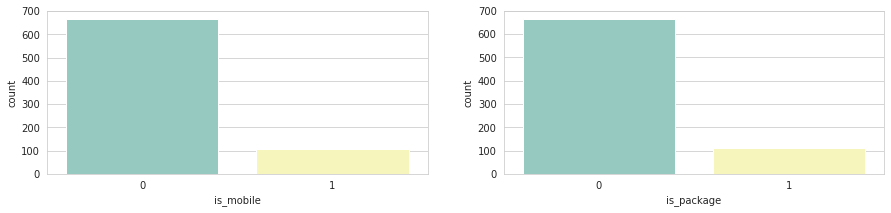

In [17]:

fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,3))

# What's the frequency of bookings through mobile?
sns.countplot(x='is_mobile',data=bookings_df, order=[0,1], palette="Set3", ax=axis1)

# What's the frequency of bookings with package?
sns.countplot(x='is_package',data=bookings_df, order=[0,1], palette="Set3", ax=axis2)

### most impactful channel

<AxesSubplot:xlabel='channel', ylabel='count'>

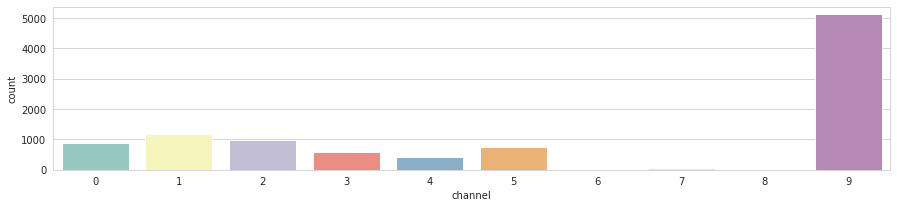

In [18]:

fig, (axis1) = plt.subplots(1,1,figsize=(15,3))

sns.countplot(x='channel', order=list(range(0,10)), data=expedia_df, palette="Set3")



### visualization check in date, Month , Week

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Month', ylabel='is_booking'>

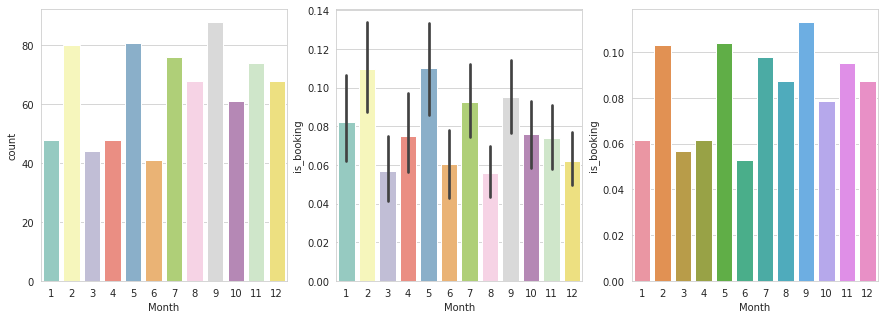

In [19]:
expedia_df['Year']   = expedia_df['srch_ci'].apply(lambda x: int(str(x)[:4]) if x == x else np.nan)
expedia_df['Month']  = expedia_df['srch_ci'].apply(lambda x: int(str(x)[5:7]) if x == x else np.nan)
expedia_df['Week']   = expedia_df['srch_ci'].apply(lambda x: int(str(x)[8:10]) if x == x else np.nan)

fig, (axis1,axis2,axis3) = plt.subplots(1,3,sharex=True,figsize=(15,5))

# Plot How many bookings in each month
sns.countplot('Month',data=expedia_df[expedia_df["is_booking"] == 1],order=list(range(1,13)),palette="Set3",ax=axis1)

# Plot The percentage of bookings of each month(sum of month bookings / count of bookings(=1 OR =0) of a month)
# sns.factorplot('Month',"is_booking",data=expedia_df, order=list(range(1,13)), palette="Set3",ax=axis2)
sns.barplot('Month',"is_booking",data=expedia_df, order=list(range(1,13)), palette="Set3",ax=axis2)

# Plot The percentage of bookings of each month compared to all bookings(sum of month bookings / count of bookings(=1) of all months)
month_sum = expedia_df[['Month', 'is_booking']].groupby(['Month'],as_index=False).sum()
month_sum['is_booking'] = month_sum['is_booking'] / len(expedia_df[expedia_df['is_booking'] == 1])

sns.barplot(x='Month', y='is_booking', order=list(range(1,13)), data=month_sum,ax=axis3) 

### visualization booking date as YYYY-MM

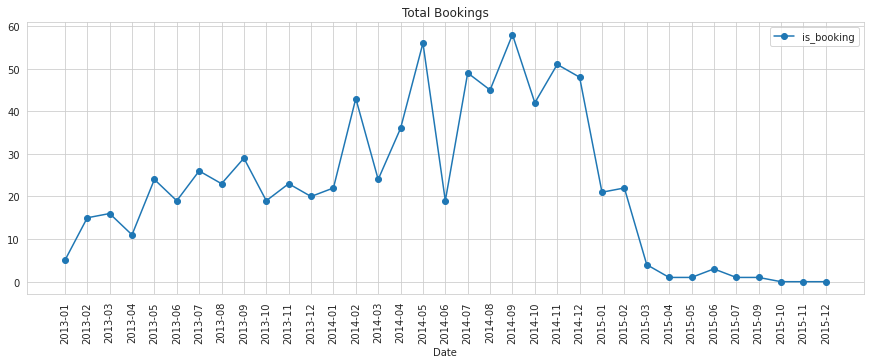

In [20]:

expedia_df['Date']  = expedia_df['srch_ci'].apply(lambda x: (str(x)[:7]) if x == x else np.nan)

# Plot number of bookings over Date
date_bookings  = expedia_df.groupby('Date')["is_booking"].sum()
ax1 = date_bookings.plot(legend=True,marker='o',title="Total Bookings", figsize=(15,5)) 
ax1.set_xticks(range(len(date_bookings)))
xlabels = ax1.set_xticklabels(date_bookings.index.tolist(), rotation=90)



In [21]:
expedia_df

,posa_continent,user_location_country,is_mobile,is_package,channel,srch_ci,srch_destination_id,srch_destination_type_id,is_booking,hotel_continent,hotel_country,hotel_market,hotel_cluster,Year,Month,Week,Date
0,3,66,0,1,9,2014-08-27,8250,1,0,2,50,628,1,2014.0,8.0,27.0,2014-08
1,3,66,0,1,9,2014-08-29,8250,1,1,2,50,628,1,2014.0,8.0,29.0,2014-08
2,3,66,0,0,9,2014-08-29,8250,1,0,2,50,628,1,2014.0,8.0,29.0,2014-08
3,3,66,0,0,3,2014-11-23,14984,1,0,2,50,1457,80,2014.0,11.0,23.0,2014-11
4,3,66,0,0,3,2014-11-23,14984,1,0,2,50,1457,21,2014.0,11.0,23.0,2014-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,3,66,1,0,1,2014-08-28,11620,1,0,2,50,369,97,2014.0,8.0,28.0,2014-08
9996,3,66,1,0,1,2014-08-28,11620,1,0,2,50,369,97,2014.0,8.0,28.0,2014-08
9997,3,66,1,0,1,2014-08-29,8835,1,0,2,50,357,69,2014.0,8.0,29.0,2014-08
9998,3,66,1,0,1,2014-08-29,8838,1,0,2,50,363,96,2014.0,8.0,29.0,2014-08


### visualization of hotel country and YYYY-MM

In [22]:

hotel_country_piv       = pd.pivot_table(expedia_df,values='is_booking', index='Date', columns=['hotel_country'],aggfunc='sum')
hotel_country_piv       = hotel_country_piv.fillna(0)
hotel_country_piv.head()

hotel_country,0,1,5,7,8,9,11,12,13,15,...,182,185,186,193,196,198,200,203,204,208
Date,,,,,,,,,,,,,,,,,,,,,
2013-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2013-03,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
2013-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2013-05,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### correlation between range of hotel country ID

<AxesSubplot:xlabel='hotel_country', ylabel='hotel_country'>

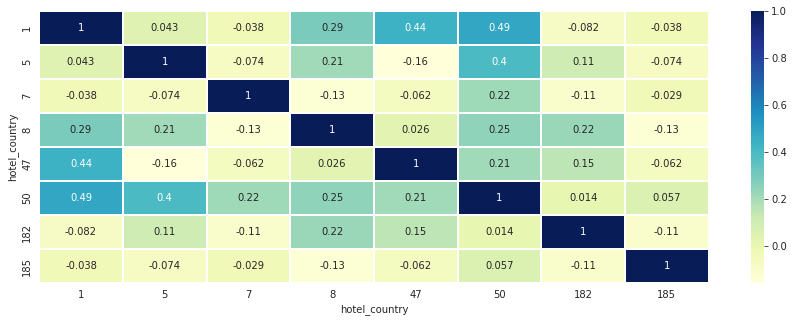

In [23]:

country_ids = [1,5,7,8,47,50,182,185]

fig, (axis1) = plt.subplots(1,1,figsize=(15,5))

# using summation of booking values for each hotel_country 
sns.heatmap(hotel_country_piv[country_ids].corr(),annot=True,linewidths=2,cmap="YlGnBu")

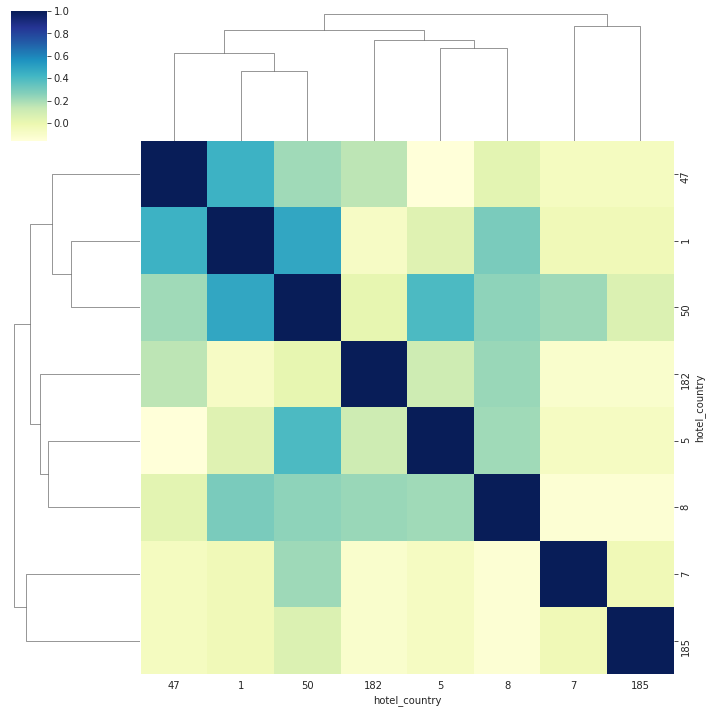

In [24]:
# .... continue Correlation

# Reformat the heatmap so similar hotel_country are next to each other
sns.clustermap(hotel_country_piv[country_ids].corr(), cmap="YlGnBu")

### Define training and testing sets


In [25]:
train_df = pd.read_csv('../input/expedia-hotel-recommendations/train.csv', usecols=['is_booking', 'srch_destination_id', 'hotel_cluster'])
test_df  = test_df[['id', 'srch_destination_id']]

### group of search id finding the sum of booking and number of click

In [26]:
train_df.columns

Index(['srch_destination_id', 'is_booking', 'hotel_cluster'], dtype='object')

In [27]:
train_df[train_df['srch_destination_id']==0]

,srch_destination_id,is_booking,hotel_cluster
14846552,0,0,3
26027493,0,0,3


In [28]:
train_df[train_df['srch_destination_id']==1]

,srch_destination_id,is_booking,hotel_cluster
485559,1,0,20
485560,1,0,60
485561,1,0,60
485562,1,0,20
485563,1,0,30
...,...,...,...
32910395,1,0,30
32910396,1,0,30
32910397,1,0,30
32910398,1,1,30


In [29]:
train_df.loc[(train_df['srch_destination_id']==1) & (train_df['hotel_cluster']==20 )]

,srch_destination_id,is_booking,hotel_cluster
485559,1,0,20
485562,1,0,20
1756689,1,0,20
1756690,1,1,20
20202873,1,0,20
22519667,1,0,20
25845473,1,0,20
25845475,1,0,20
25845476,1,0,20
27411558,1,0,20


### sum is the sum of transaction that is booking
### count is the total number of transaction it show up

In [30]:

train_df = train_df.groupby(['srch_destination_id','hotel_cluster'])['is_booking'].agg(['sum','count'])
train_df

sum  count
srch_destination_id hotel_cluster            
0                   3                0      2
1                   20               4     26
                    30               2     22
                    57               0      1
                    60               0     17
...                                ...    ...
65103               42               0      3
                    50               0      1
65104               5                0      1
                    37               1      2
65107               76               0      1

[396024 rows x 2 columns]

In [31]:
### now we exclude itself from the count

train_df['count'] = train_df['count'] - train_df['sum']
train_df


sum  count
srch_destination_id hotel_cluster            
0                   3                0      2
1                   20               4     22
                    30               2     20
                    57               0      1
                    60               0     17
...                                ...    ...
65103               42               0      3
                    50               0      1
65104               5                0      1
                    37               1      1
65107               76               0      1

[396024 rows x 2 columns]

In [32]:
train_df.rename(columns={'sum': 'sum_bookings', 'count': 'clicks'}, inplace=True)

# For each destination id & hotel cluster, 
# the relevance will be the number of bookings made + number of clicks(no-bookings) * 0.1
# meaning for every 10 clicks, they will be counted as 1 booking

train_df['relevance'] = train_df['sum_bookings'] + (train_df['clicks'] * 0.1)

In [33]:
train_df

sum_bookings  clicks  relevance
srch_destination_id hotel_cluster                                 
0                   3                         0       2        0.2
1                   20                        4      22        6.2
                    30                        2      20        4.0
                    57                        0       1        0.1
                    60                        0      17        1.7
...                                         ...     ...        ...
65103               42                        0       3        0.3
                    50                        0       1        0.1
65104               5                         0       1        0.1
                    37                        1       1        1.1
65107               76                        0       1        0.1

[396024 rows x 3 columns]

In [34]:
train_df_copy = train_df.copy()

In [35]:
train_df_copy2 = train_df_copy.reset_index()

In [36]:
train_df_copy2

,srch_destination_id,hotel_cluster,sum_bookings,clicks,relevance
0,0,3,0,2,0.2
1,1,20,4,22,6.2
2,1,30,2,20,4.0
3,1,57,0,1,0.1
4,1,60,0,17,1.7
...,...,...,...,...,...
396019,65103,42,0,3,0.3
396020,65103,50,0,1,0.1
396021,65104,5,0,1,0.1
396022,65104,37,1,1,1.1


### each destination we get the top 5 of relevence

### exploring each destination id

In [37]:
train_df_copy2[train_df_copy2['srch_destination_id']==1]

,srch_destination_id,hotel_cluster,sum_bookings,clicks,relevance
1,1,20,4,22,6.2
2,1,30,2,20,4.0
3,1,57,0,1,0.1
4,1,60,0,17,1.7


In [38]:
train_df_copy2[train_df_copy2['srch_destination_id']==4]

,srch_destination_id,hotel_cluster,sum_bookings,clicks,relevance
14,4,3,1,9,1.9
15,4,14,0,4,0.4
16,4,20,0,9,0.9
17,4,22,12,62,18.2
18,4,25,23,112,34.2
19,4,29,3,27,5.7
20,4,30,14,80,22.0
21,4,32,22,81,30.1
22,4,35,0,1,0.1
23,4,38,11,43,15.3


In [39]:

def get_top_clusters(group):
    indexes      = group.relevance.nlargest(5).index
    top_clusters = group.hotel_cluster[indexes].values
    if(len(top_clusters) < 5):
        top_clusters = (list(top_clusters) + list(ferq_clusters.index))[:5]
    return np.array_str(np.array(top_clusters))[1:-1]

train_df      = train_df.reset_index()
ferq_clusters = train_df['hotel_cluster'].value_counts()[:5]
top_clusters  = train_df.groupby(['srch_destination_id']).apply(get_top_clusters)

In [40]:
top_clusters

srch_destination_id
0         3 30 20 85  3
1        20 30 60 57 30
2        20 30  5 38 41
3        53 60 30 20 85
4        82 25 32 78 58
              ...      
65098    94 50 30 20 85
65102     7 51 30 20 85
65103    42  7 20 50 30
65104    37  5 30 20 85
65107    76 30 20 85  3
Length: 59455, dtype: object

In [41]:
# Create top_clusters_df

top_clusters_df = pd.DataFrame(top_clusters).rename(columns={0: 'hotel_cluster'})
top_clusters_df.head()

,hotel_cluster
srch_destination_id,
0,3 30 20 85 3
1,20 30 60 57 30
2,20 30 5 38 41
3,53 60 30 20 85
4,82 25 32 78 58


In [42]:
top_clusters_df['hotel_cluster'][0].split()

['3', '30', '20', '85', '3']

### Merge test dataset with top_clusters_df

In [43]:


# For every destination id in test_df, merge it with the corresponding id in top_clusters_df 
test_df = pd.merge(test_df, top_clusters_df, how='left',left_on='srch_destination_id', right_index=True)

test_df


,id,srch_destination_id,hotel_cluster
0,0,12243,5 37 55 11 22
1,1,14474,5 30 20 85 3
2,2,11353,0 31 96 91 77
3,3,8250,1 45 79 24 54
4,4,11812,91 42 2 48 59
...,...,...,...
2528238,2528238,8857,26 73 84 0 34
2528239,2528239,19308,57 30 20 85 3
2528240,2528240,8250,1 45 79 24 54
2528241,2528241,4627,50 47 43 15 32


In [44]:
# Fill NaN values with most frequent clusters
test_df.hotel_cluster.fillna(np.array_str(ferq_clusters.index)[1:-1],inplace=True)

Y_pred = test_df["hotel_cluster"]

In [45]:
# Create submission

submission = pd.DataFrame()
submission["id"]            = test_df["id"]
submission["hotel_cluster"] = Y_pred

submission.to_csv('expedia.csv', index=False)

##### 